In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
!pip3 install tornado --user
!pip3 install yfinance --upgrade --ignore-installed six --user
!pip3 uninstall pandas_datareader -y
#!pip install --upgrade pip --user
!pip3 install pandas_datareader --upgrade --no-cache-dir --ignore-installed six --user
!pip3 install yfinance

Processing /Users/vashistagande/Library/Caches/pip/wheels/1b/9d/ce/929e851fc7d649cd962c177220ad985675785aa97c54df5714/yfinance-0.1.52-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/65/26/32b8464df2a97e6dd1b656ed26b2c194606c16fe163c695a992b36c11cdf/six-1.13.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/52/ca/f986280226b62da6ae5474589a369b0d240f9a61a99144a501b45f108883/pandas-0.25.3-cp38-cp38-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/69/e7/e9f1661c28f7b87abfa08cb0e8f51dad2240a9f4f741f02ea839835e6d18/multitasking-0.0.9.tar.gz
  Using cached https://files.pythonhosted.org/packages/9e/cf/7cea38d32df6087d7c15bca8edef0be82e0d957119e9dafd7052dc6192f0/numpy-1.17.4-cp38-cp38-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/51/bd/23c926cd341ea6b7dd0b2a00aba99ae0f828be89d72b2190f27c11d4b7fb/requests-2.22.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/p

In [3]:
from pandas_datareader import data as pdr
import yfinance as yf
import datetime
start = datetime.datetime(2018,1,1)
end= datetime.datetime(2019,12,1)
yf.pdr_override()
df_full = yf.download("jpm",start = start,end=end).reset_index()
df_full.to_csv('jpm.csv',index=False)
df_full.head()
import pandas as pd
df = pd.read_csv('jpm.csv')
df
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg

ModuleNotFoundError: No module named 'pandas_datareader'

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1671    107.1599
1672    107.2070
1673    107.2598
1674    107.3340
1675    107.3918
Name: Adj Close, Length: 1676, dtype: float64

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1671    107.1599
1672    107.2070
1673    107.2598
1674    107.3340
1675    107.3918
Name: Adj Close, Length: 1676, dtype: float64

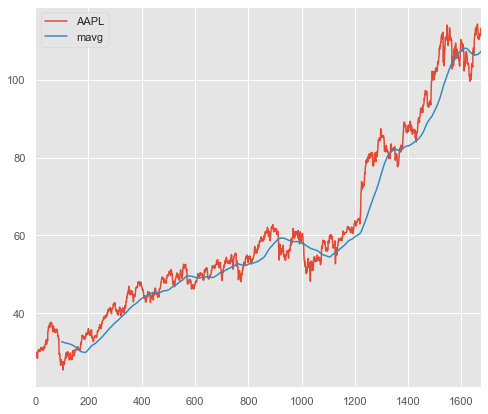

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

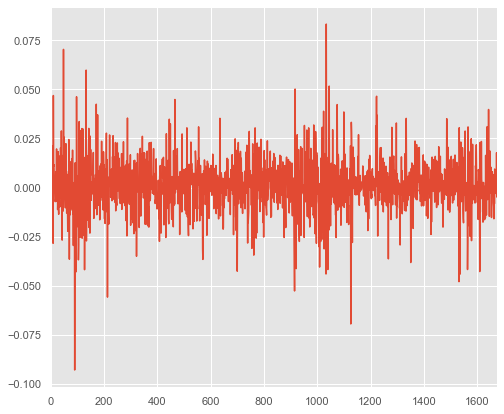

In [6]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [7]:
dfcomp = yf.download(['jpm','AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],start = start,end=end)['Adj Close']
dfcomp

NameError: name 'yf' is not defined

In [8]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()
corr

NameError: name 'dfcomp' is not defined

Text(0, 0.5, 'Returns GE')

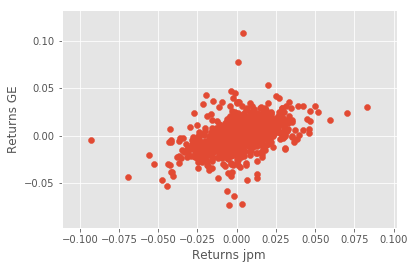

In [11]:
plt.scatter(retscomp.JPM, retscomp.GE)
plt.xlabel('Returns jpm')
plt.ylabel('Returns GE')

In [9]:
from pandas.plotting import scatter_matrix
scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

NameError: name 'retscomp' is not defined

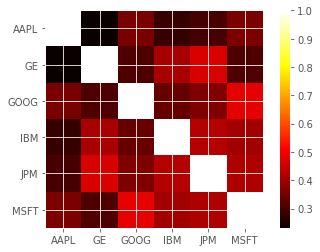

In [13]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

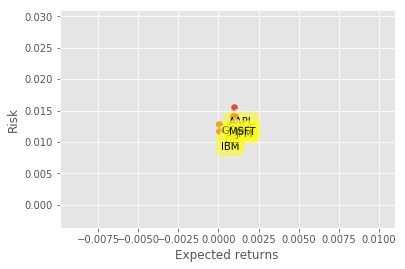

In [14]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [15]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High']-df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close']-df['Open']) / df['Open'] * 100.0

In [16]:
import math
import numpy as np
from sklearn import preprocessing
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [17]:
X

array([[-1.40177278,  2.19456689,  1.74914972,  2.39022866],
       [-1.39393436,  1.53702565,  0.68428462,  1.29191488],
       [-1.36824176,  1.69506394,  2.66844485,  2.47435464],
       ...,
       [ 2.2770595 , -0.69037828, -0.03434335,  1.20031968],
       [ 2.31668707, -0.69404507, -0.694447  ,  0.8048243 ],
       [ 2.31799347, -0.79520458, -0.55308835,  0.2134037 ]])

In [18]:
y

array([ 30.29,  30.12,  30.36, ..., 113.29, 112.74, 112.37])

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [21]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly.fit(X_train, y_train)

# ridge regression
clfridge = Ridge() 
clfridge.fit(X_train, y_train)

#Lasso regression
clflasso = Lasso()
clflasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [22]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

In [23]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly = clfpoly.score(X_test,y_test)
confidenceridge = clfridge.score(X_test,y_test)
confidencelasso = clflasso.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

In [24]:
print(confidencereg)
print(confidencepoly)
print(confidenceridge)
print(confidencelasso)
print(confidenceknn)

0.9824819392704278
0.9819979239413872
0.9824719358961523
0.9807389439550847
0.9596264436553583


In [25]:
forecast_set =clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan
forecast_set

array([115.24541176, 115.47405792, 114.62501831, 113.49273443,
       111.98492804, 112.48344354, 111.58085934, 112.52287633,
       112.50157539, 112.39197063, 113.17697461, 112.6841624 ,
       112.45678512, 112.42590953, 114.56235004, 113.94766077,
       113.56654577])

In [10]:
# last_date = dfreg.iloc[-1].name
# last_unix = last_date
# next_unix = last_unix + datetime.timedelta(days=1)
next_unix =  datetime.datetime.now() + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

NameError: name 'datetime' is not defined